<a href="https://colab.research.google.com/github/rohan1596gupta/TimeSeries/blob/master/arima_electricity_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from pandas import Timestamp
from datetime import datetime
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/Actual_consumption.csv', sep = ';')

In [123]:
df.isnull().sum()

Date           0
Time of day    0
Total[MWh]     0
dtype: int64

In [0]:
df['Date'] = df['Date'].str.replace(',', ' ')
df['Total'] = df['Total[MWh]'].str.replace(',','')
df['Total'] = df['Total'].str.replace('.','')

In [0]:
df['Total'] = pd.to_numeric(df['Total'], errors = 'coerce' )
df['Date'] = pd.to_datetime(df['Date'])
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time of day']) 

In [0]:
df.drop(columns=['Date','Time of day', 'Total[MWh]'], inplace=True)
df.columns = ['Total','DateTime']
df = df.reindex(columns=['DateTime','Total'])

In [0]:
df = df.set_index(['DateTime'])

In [0]:
df = df.resample('12H').mean()

In [0]:
import plotly.express as px

In [146]:
df_copy = df
fig = px.line(df_copy,x=df_copy.index,y=df_copy['Total'])
fig.show()

In [147]:
df_copy.head()

,Total
DateTime,
2018-01-01 00:00:00,502524.833333
2018-01-01 12:00:00,707009.333333
2018-01-02 00:00:00,829509.770833
2018-01-02 12:00:00,817453.187500
2018-01-03 00:00:00,802814.041667


In [149]:
df_copy.replace(df_copy[df_copy.values <= 400000.00], np.nan, inplace=True)
df_copy['Total'].isna().sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in less_equal



440

### *From the above we see that there were 400 rows which had total consumption power less than 400,000 MW. Therefore we replaced them with 'na' so that we can impute them with KNN imputer*



In [0]:
## Imputing missing value using KNN
from sklearn.impute import KNNImputer
NaN = np.nan
imputer = KNNImputer(missing_values = NaN, n_neighbors=5, weights="uniform")
total_new = imputer.fit_transform(df_copy.values)

In [0]:
## Converting the array back into dataframe 
df_imputed = pd.DataFrame(total_new, index=df_copy.index, columns=df_copy.columns)

In [153]:
df_imputed['Total'].isnull().sum()

0

In [162]:
df_final = df_imputed[0:1085]
fig = px.line(df_final,x=df_final.index,y=df_final['Total'])
fig.show()

In [164]:
## Augmented Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller

X = df_final['Total'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.389445
p-value: 0.000310
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


We can see from the ADF statisitc=-4.38 < -3.437 therefore we can reject the null hypothesis or can say the series is stationary. Also the p y <= 0.05


In [166]:
## KPSS Test
from statsmodels.tsa.stattools import kpss

X = df_final['Total'].values
result = kpss(X)
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
	print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.427347
p-value: 0.065368
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'



Test statistic  > Critical value -> trend stationary

In [167]:
'''
## Augmented Dickey Fuller Test with log() to stationatise the ts
from statsmodels.tsa.stattools import adfuller

from numpy import log
X = df_copy['Total'].values
#X= log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

'''

"\n## Augmented Dickey Fuller Test with log() to stationatise the ts\nfrom statsmodels.tsa.stattools import adfuller\n\nfrom numpy import log\nX = df_copy['Total'].values\n#X= log(X)\nresult = adfuller(X)\nprint('ADF Statistic: %f' % result[0])\nprint('p-value: %f' % result[1])\nprint('Critical Values:')\nfor key, value in result[4].items():\n\tprint('\t%s: %.3f' % (key, value))\n\n"

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



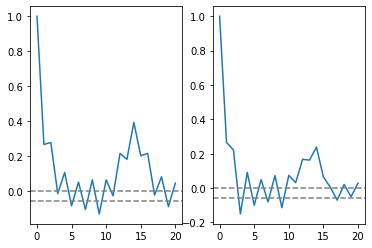

In [168]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
#autocorrelation_plot(df_final, 20)
lag_acf = acf(df_final, nlags = 20)
lag_pacf = pacf(df_final, nlags = 20, method = 'ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(df_final)), linestyle = '--', color = 'gray')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(df_final)), linestyle = '--', color = 'gray')

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1085
Model:                     ARMA(4, 0)   Log Likelihood              -14281.522
Method:                       css-mle   S.D. of innovations         125948.382
Date:                Sat, 29 Feb 2020   AIC                          28575.045
Time:                        18:44:35   BIC                          28604.981
Sample:                             0   HQIC                         28586.378
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.607e+05   6400.166    118.856      0.000    7.48e+05    7.73e+05
ar.L1.y        0.2546      0.030      8.412      0.000       0.195       0.314
ar.L2.y        0.2301      0.031      7.474      0.0

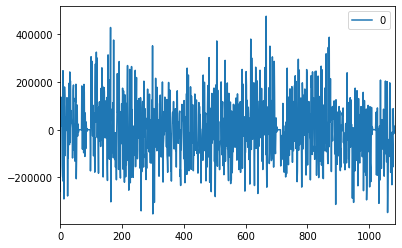

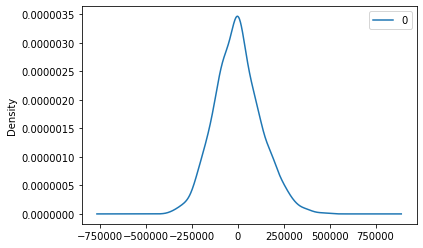

                   0
count    1085.000000
mean        5.795670
std    126043.784248
min   -353014.236232
25%    -84103.161825
50%     -1067.449714
75%     76182.036230
max    475742.629339


In [169]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas import DataFrame
 
series = df_final.values
# fit model
model = ARIMA(series, order=(4,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

predicted=707489.191175, expected=584652.520833
predicted=731598.076756, expected=624729.104167
predicted=707406.181965, expected=599690.125000
predicted=724727.388433, expected=685513.916667
predicted=725166.414434, expected=622142.000000
predicted=737460.693116, expected=833879.250000
predicted=751814.464077, expected=620742.145833
predicted=770404.903843, expected=662775.145833
predicted=686272.422531, expected=667868.979167
predicted=755555.023295, expected=567370.812500
predicted=708119.364449, expected=674527.687500
predicted=712025.995516, expected=673084.645833
predicted=754768.036327, expected=667459.625000
predicted=723983.350132, expected=730974.958333
predicted=745988.244526, expected=540887.541667
predicted=718343.813975, expected=669269.958333
predicted=692082.530918, expected=716476.250000
predicted=772406.419130, expected=579978.520833
predicted=711683.698128, expected=732859.354167
predicted=717388.147304, expected=969496.145833
predicted=833492.662099, expected=844116

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=765041.904602, expected=682563.979167
predicted=753256.195156, expected=806837.708333
predicted=754080.429092, expected=933081.416667
predicted=827142.983008, expected=880119.687500
predicted=812751.156610, expected=679053.166667
predicted=742066.891633, expected=860710.291667
predicted=759152.964921, expected=777595.437500
predicted=813629.823664, expected=724881.208333
predicted=734172.297134, expected=808420.437500
predicted=770938.593364, expected=721805.416667
predicted=773190.612461, expected=940900.583333
predicted=783114.767901, expected=972422.791667
predicted=860639.507930, expected=916538.708333
predicted=807902.029060, expected=1040600.666667
predicted=835748.723763, expected=887866.354167
predicted=841853.442446, expected=771226.125000
predicted=754699.849725, expected=960599.979167
predicted=809932.971763, expected=756288.104167
predicted=815073.734424, expected=836668.437500
predicted=745210.608911, expected=527609.208333
predicted=745208.700936, expected=56336

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=728504.462485, expected=549379.229167
predicted=718183.411496, expected=654877.958333
predicted=701358.784908, expected=711713.437500
predicted=764007.238182, expected=778550.104167
predicted=763992.071156, expected=708423.395833
predicted=759048.024298, expected=611295.562500
predicted=712684.965921, expected=616999.229167
predicted=710930.078099, expected=939052.291667
predicted=802584.332080, expected=802665.375000
predicted=829099.375777, expected=841369.875000
predicted=751999.863067, expected=703398.895833
predicted=776982.430958, expected=887502.020833
predicted=774408.189643, expected=646417.145833
predicted=783566.429520, expected=761384.854167
predicted=715358.532865, expected=548165.562500
predicted=747161.799566, expected=713612.500000
predicted=700700.099841, expected=653053.875000
predicted=769730.413485, expected=893412.312500
predicted=767164.870584, expected=685560.812500
predicted=793393.864979, expected=911944.875000
predicted=753494.769082, expected=771103

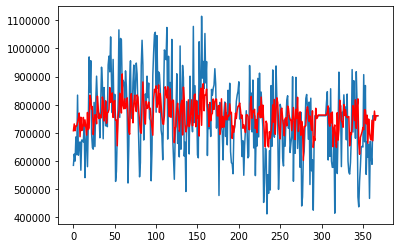

In [170]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
 
X = series ## Series is initialzed with df_final in the above cell
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(4,0,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [172]:
predictions = pd.DataFrame(model_fit.fittedvalues)
predictions

,0
0,760699.079651
1,691869.416302
2,692287.486016
3,802581.245880
4,776746.613553
...,...
1079,737819.021487
1080,777257.262749
1081,745000.172557
1082,760699.079651


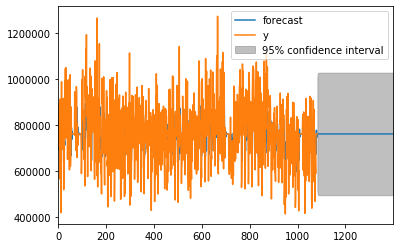

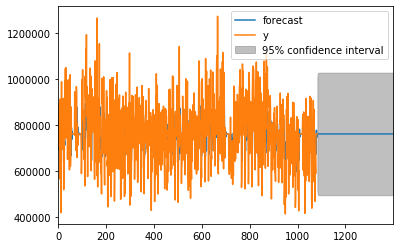

In [176]:
model_fit.plot_predict(1,1400)